# High number of transcripts caused by specific tissue or sample size

Reviewers were wondering why so many new transcripts (60%) <br>
"<br>
Moreover, it would be interesting to analyze, **whether the putatively novel transcripts are originating from specific datasets and/or tissues**. The link to the dataset(s) could be made available for unique tissue-transcript combinations.<br>
"<br>
"<br>
How would figure S2 look like if it were corrected by number of analysed tissues?<br>
"<br>


In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr


## More samples more aGPCRs > 0.1/0.5 TPM per tissue?

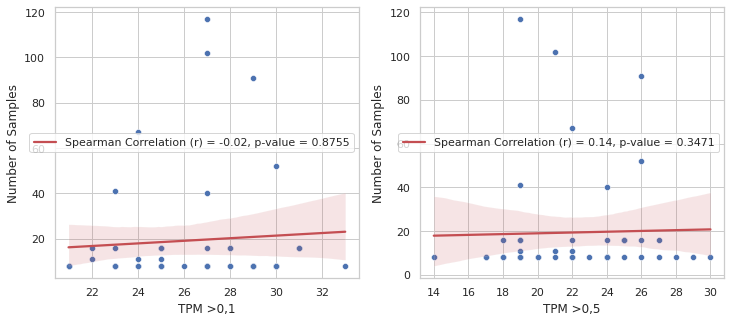

In [90]:
aGPCR_expression = pd.read_csv("Suppl_Table_S6_Expression_analysis.csv", index_col=0)
number_of_samples_per_tissue = pd.read_csv("Suppl_Table_S2_Tissues.csv", index_col=0)
#get row "TPM >0,1" from aGPCR_expression

row_tpm_1 = aGPCR_expression.loc['TPM >0,1']
row_tpm_5 = aGPCR_expression.loc['TPM >0,5']
   

new_index = number_of_samples_per_tissue.index.to_list()

number_of_samples_per_tissue.rename(index=dict(zip(number_of_samples_per_tissue.index, row_tpm_1.index)), inplace=True)

result = pd.concat([row_tpm_1, number_of_samples_per_tissue["Number of Samples"]], axis=1)
result.sort_values(by="TPM >0,1", ascending=False)


# Assuming df is your DataFrame
# Replace 'column1' and 'column2' with your actual column names

# Scatter plot for TPM >0,1
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 1: TPM >0,1
scatter_plot1 = sns.scatterplot(x='TPM >0,1', y='Number of Samples', data=result, ax=axes[0])

# Calculate and display the Spearman correlation coefficient for TPM >0,1
spearman_corr1, p_value1 = spearmanr(result['TPM >0,1'], result['Number of Samples'])

# Plot the correlation line for TPM >0,1
sns.regplot(x='TPM >0,1', y='Number of Samples', data=result, scatter=False, ax=scatter_plot1, color='r',
            label=f'Spearman Correlation (r) = {spearman_corr1:.2f}, p-value = {p_value1:.4f}')

# Add legend
scatter_plot1.legend()

result = pd.concat([row_tpm_5, number_of_samples_per_tissue["Number of Samples"]], axis=1)
result.sort_values(by="TPM >0,5", ascending=False)

# Plot 2: TPM >0,5
scatter_plot2 = sns.scatterplot(x='TPM >0,5', y='Number of Samples', data=result, ax=axes[1])

# Calculate and display the Spearman correlation coefficient for TPM >0,5
spearman_corr2, p_value2 = spearmanr(result['TPM >0,5'], result['Number of Samples'])

# Plot the correlation line for TPM >0,5
sns.regplot(x='TPM >0,5', y='Number of Samples', data=result, scatter=False, ax=scatter_plot2, color='r',
            label=f'Spearman Correlation (r) = {spearman_corr2:.2f}, p-value = {p_value2:.4f}')

# Add legend
scatter_plot2.legend()

plt.show()

I plotted the number of aGPCRs which sum >0.1TPMs(>0.5TPMs) (in one tissue) vs the number of samples corresponding to the tissue <br>
-> we dont see a correlation that we have a higher number of TPMs if the number of samples contrubing to the tissue is higher too <br>
-> therefore more samples per tissues does not mean higher TPMs per gene <br>

## Per aGPCR: Each tissue vs. number of transcripts
how many of aGPCRs have expression under 0.1TPM

In [198]:
# Provide the path to your Excel file
excel_file_path = 'Suppl_Table_S5_Transcripts_in_tissues.xlsx'

# Read all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(excel_file_path, sheet_name=None)
aGPCRs_dict = {}

# Iterate through each sheet
for sheet_name, sheet_df in all_sheets.items():
    if sheet_name == "Index":
        continue
#     if sheet_name != "ADGRA1":
#         continue #just for save time while testing
    
    sheed_cleaned = sheet_df.drop(columns=["gene_id","gene_name","length (bp)","start","end","# of exons"])
    sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
    sheed_cleaned = sheed_cleaned.dropna()
    prefixes_to_keep = ['NSTRG', 'XM', 'XR', 'XP','NM']
    mask = sheed_cleaned['transcript_id'].str.startswith(tuple(prefixes_to_keep)).fillna(False)
    sheed_cleaned = sheed_cleaned[mask]

    sheed_cleaned["over_tissues"] = sheed_cleaned.mean(axis=1)
    sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('(mean)'))]
    sheed_cleaned = sheed_cleaned.sort_values("over_tissues")
    
    #### LOW EXPRESSED transcripts
    
    #calculate the % of transcripts that are under 0.1 TPMs 
    percentage_below_01 = (sheed_cleaned['over_tissues'] < 0.1).mean() * 100
    number_01 = (sheed_cleaned['over_tissues'] < 0.1).sum()
    
    ### NEWLY TRANSCRIPTS
    # Filter transcripts starting with "NSTRG"
    nstrg_transcripts = sheed_cleaned[sheed_cleaned['transcript_id'].str.startswith('NSTRG')]
    # Get the count
    num_nstrg_transcripts = len(nstrg_transcripts)
    percentage_nstrg_transcripts = (num_nstrg_transcripts/sheed_cleaned.shape[0])*100

    aGPCRs_dict[sheet_name] = number_01,percentage_below_01,num_nstrg_transcripts,percentage_nstrg_transcripts
    
#     plt.figure(figsize=(10, 6))
#     plt.scatter(sheed_cleaned["transcript_id"], sheed_cleaned["over_tissues"], color='skyblue')
#     plt.axhline(y=0.1, color='red', linestyle='--', label='Threshold (0.1 TPM)')
#     plt.xlabel('Transcript ID')
#     plt.ylabel('Over Tissues Value')
#     plt.title(sheet_name)
#     plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
#     plt.savefig("output/"+sheet_name+".png")
#     plt.show()
#     plt.clf()


# sheed_cleaned
df = pd.DataFrame.from_dict(aGPCRs_dict)
df = df.transpose()
new_col = ["number of transcripts under 0.1 TPM","% of transcipts under 0.1 TPM","number of NSTRG transcripts","% of NSTRG transcripts"]
df.set_axis(new_col, axis=1).to_csv("low_expressed_and_newly.csv")

/home/christina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()
/home/christina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/christina/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
